# Project of Advanced Machine Learning

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import csv
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import tarfile
import PIL
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

## Utility functions

In [2]:
def get_image_names(tgz):
    with tarfile.open(tgz) as file:
        return [i.name for i in file.getmembers() if i.isfile()]

def show_random_images(n=4, size=10, label=None):
    if(label != None):
        images = df[df['label'] == str(label)].sample(n=(n*n))
    else:
        images = df.sample(n=(n*n))
        
    plt.figure(figsize=(size, size))
    for index, path in enumerate(images['id'].values):
        plt.subplot(n, n, index+1)
        plt.imshow(PIL.Image.open(DATA_PATH + 'images/' + path))
        plt.title('Label: ' + str(images['label'].values[index]))
        plt.axis('off')
    plt.show()

def show_random_images_aug(aug, n=2, size=10):
    x, y = aug.next()
    
    plt.figure(figsize=(size, size))
    for i in range(0, (n*n)):
        plt.subplot(n, n, i+1)
        plt.imshow(x[i])
        plt.title('Label: ' + str(np.where(y[i] == 1)[0][0]))
        plt.axis('off')
    plt.show()
    
def plot_history(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'], 'orange', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], 'royalblue', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], 'orange', label='Training Loss')
    plt.plot(history.history['val_loss'], 'royalblue', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

## Configuration parameters

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [4]:
DATA_PATH = '/content/drive/My Drive/data/' #  './data/'

plt.style.use('dark_background')

TEST_RATIO = 0.3
VALIDATION_RATIO = 0.2
NUM_CLASSES = 102
IMG_SIZE = 250
IMG_CHANNELS = 3
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

SEED = 42
np.random.seed(SEED)

VERBOSE = 1
BATCH_SIZE = 32
PATIENCE = 10

CHECKPOINT = ModelCheckpoint((DATA_PATH + 'model.hdf5'), monitor=['val_accuracy'], verbose=VERBOSE, mode='max')
EARLYSTOP = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, restore_best_weights=True)

## Base models

In [5]:
model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
model_vgg.trainable = False

model_vgg.summary()

model_xception = Xception(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
model_xception.trainable = False

model_xception.summary()

model_resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
model_resnet.trainable = False

model_resnet.summary()

58892288/58889256 [==============================] - 27s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_____________________________________________________________

block12_sepconv1 (SeparableConv (None, 16, 16, 728)  536536      block12_sepconv1_act[0][0]       
__________________________________________________________________________________________________
block12_sepconv1_bn (BatchNorma (None, 16, 16, 728)  2912        block12_sepconv1[0][0]           
__________________________________________________________________________________________________
block12_sepconv2_act (Activatio (None, 16, 16, 728)  0           block12_sepconv1_bn[0][0]        
__________________________________________________________________________________________________
block12_sepconv2 (SeparableConv (None, 16, 16, 728)  536536      block12_sepconv2_act[0][0]       
__________________________________________________________________________________________________
block12_sepconv2_bn (BatchNorma (None, 16, 16, 728)  2912        block12_sepconv2[0][0]           
__________________________________________________________________________________________________
block12_se

__________________________________________________________________________________________________
conv2_block1_out (Add)          (None, 63, 63, 256)  0           conv2_block1_0_conv[0][0]        
                                                                 conv2_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv2_block2_preact_bn (BatchNo (None, 63, 63, 256)  1024        conv2_block1_out[0][0]           
__________________________________________________________________________________________________
conv2_block2_preact_relu (Activ (None, 63, 63, 256)  0           conv2_block2_preact_bn[0][0]     
__________________________________________________________________________________________________
conv2_block2_1_conv (Conv2D)    (None, 63, 63, 64)   16384       conv2_block2_preact_relu[0][0]   
__________________________________________________________________________________________________
conv2_bloc

## Import data

In [6]:
df = pd.DataFrame()
df['id'] = sorted(get_image_names(DATA_PATH + 'images.tgz'))
df['label'] = scipy.io.loadmat(DATA_PATH + 'labels.mat')['labels'][0] - 1
df['label'] = df['label'].astype('str')

tarfile.open(DATA_PATH + 'images.tgz').extractall(DATA_PATH + 'images/')

Dimensione dataset:
id       8189
label    8189
dtype: int64

Lista immagini:
['image_07088.jpg', 'image_06396.jpg', 'image_05847.jpg', 'image_04581.jpg', 'image_03588.jpg', 'image_02696.jpg', 'image_07936.jpg', 'image_00081.jpg', 'image_07922.jpg', 'image_00095.jpg']

Dataframe:
                    id label
0  jpg/image_00001.jpg    76
1  jpg/image_00002.jpg    76
2  jpg/image_00003.jpg    76
3  jpg/image_00004.jpg    76
4  jpg/image_00005.jpg    76
5  jpg/image_00006.jpg    76
6  jpg/image_00007.jpg    76
7  jpg/image_00008.jpg    76
8  jpg/image_00009.jpg    76
9  jpg/image_00010.jpg    76

Numero di classi:
102

Conteggio delle immagini per ogni classe:
50    258
76    251
45    196
72    194
88    184
     ... 
26     40
2      40
44     40
20     40
0      40
Name: label, Length: 102, dtype: int64

Esempio immagini:


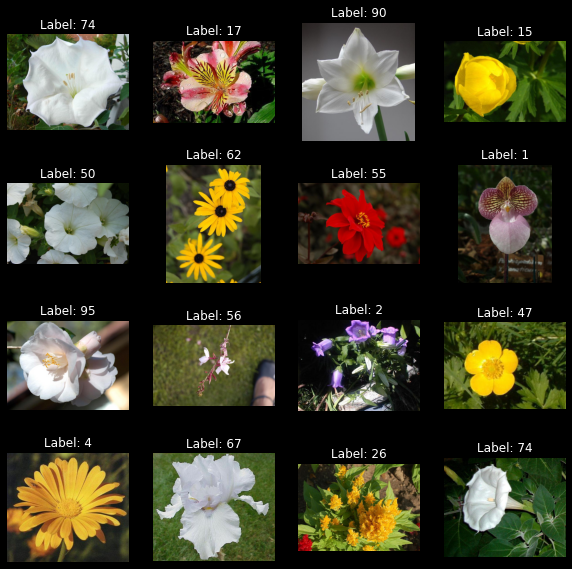

In [7]:
print('Dimensione dataset:')
print(df.count())

print('\nLista immagini:')
print(os.listdir(DATA_PATH + 'images/jpg')[:10])

print('\nDataframe:')
print(df.head(10))

print('\nNumero di classi:')
print(df['label'].nunique())

print('\nConteggio delle immagini per ogni classe:')
print(df['label'].value_counts())

print('\nEsempio immagini:')
show_random_images()

## Dataset split

In [8]:
train_X, test_X, train_y, test_y = train_test_split(
    df['id'], 
    df['label'], 
    test_size=TEST_RATIO, 
    random_state=SEED, 
    stratify=df['label']
)

train_X, validation_X, train_y, validation_y = train_test_split(
    train_X, 
    train_y, 
    test_size=(VALIDATION_RATIO/(1-TEST_RATIO)), 
    random_state=SEED,
    stratify=train_y
)

train = pd.DataFrame(train_X)
train['label'] = train_y

validation = pd.DataFrame(validation_X)
validation['label'] = validation_y

test = pd.DataFrame(test_X)
test['label'] = test_y

In [9]:
print('Dimensione del train set:')
print(train.shape)

print('\nDataframe del train set:')
print(train.head(10))

print('\nConteggio delle immagini per ogni classe del train set:')
print(train['label'].value_counts())

print('\nDimensione del validation set:')
print(validation.shape)

print('\nDataframe del validation set:')
print(validation.head(10))

print('\nConteggio delle immagini per ogni classe del validation set:')
print(validation['label'].value_counts())

print('\nDimensione del test set:')
print(test.shape)

print('\nDataframe del test set:')
print(test.head(10))

print('\nConteggio delle immagini per ogni classe del test set:')
print(test['label'].value_counts())

Dimensione del train set:
(4094, 2)

Dataframe del train set:
                       id label
4992  jpg/image_04993.jpg    46
3005  jpg/image_03006.jpg    59
4026  jpg/image_04027.jpg    11
7866  jpg/image_07867.jpg    98
5438  jpg/image_05439.jpg    53
3640  jpg/image_03641.jpg    52
6106  jpg/image_06107.jpg    63
7425  jpg/image_07426.jpg    93
586   jpg/image_00587.jpg    87
562   jpg/image_00563.jpg    87

Conteggio delle immagini per ogni classe del train set:
50    129
76    126
45     98
72     97
88     92
     ... 
33     20
0      20
2      20
44     20
26     20
Name: label, Length: 102, dtype: int64

Dimensione del validation set:
(1638, 2)

Dataframe del validation set:
                       id label
3985  jpg/image_03986.jpg    50
816   jpg/image_00817.jpg    80
3204  jpg/image_03205.jpg    64
4948  jpg/image_04949.jpg    19
3268  jpg/image_03269.jpg    64
7956  jpg/image_07957.jpg   100
6510  jpg/image_06511.jpg    25
935   jpg/image_00936.jpg    80
5263  jpg/image_052

## Data preprocessing

<AxesSubplot:>

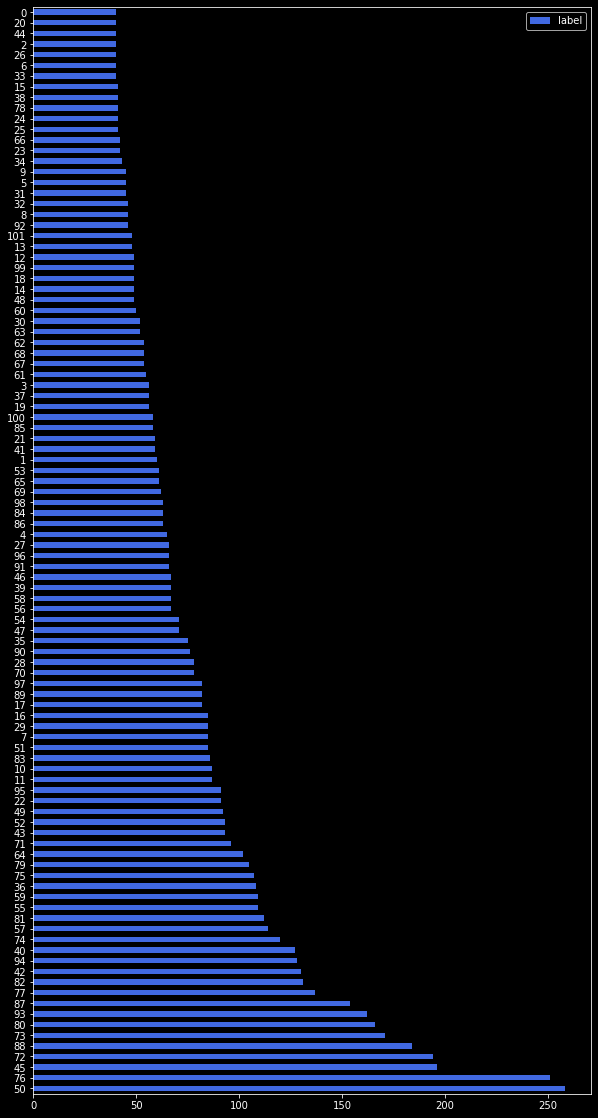

In [10]:
pd.DataFrame(df['label'].value_counts(sort=True)).plot(kind='barh', figsize=(10, 20), color='royalblue')

<AxesSubplot:>

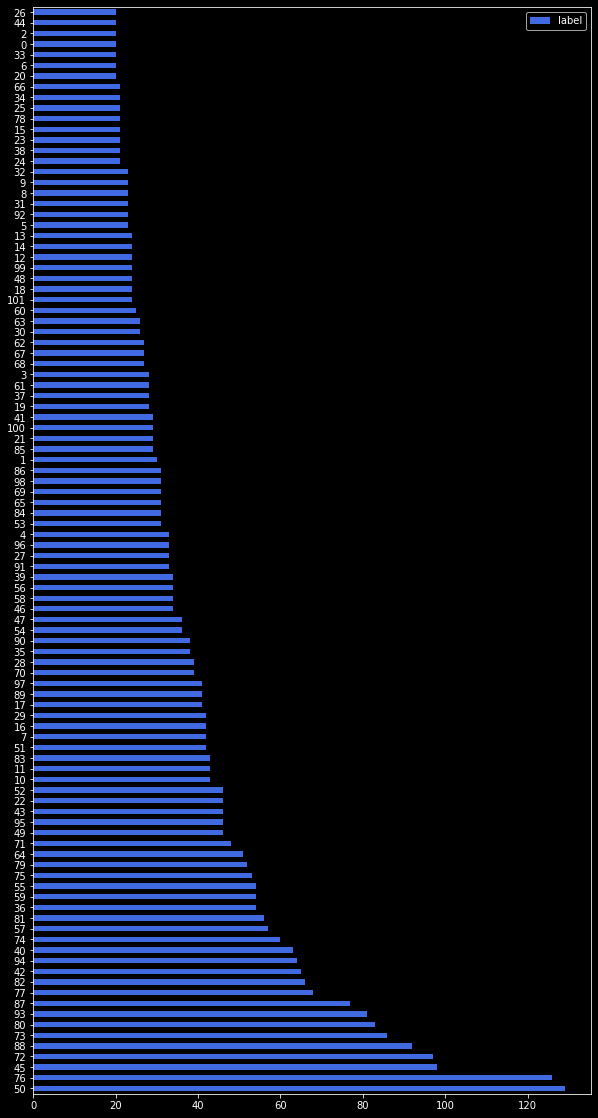

In [11]:
pd.DataFrame(train['label'].value_counts(sort=True)).plot(kind='barh', figsize=(10, 20), color='royalblue')

<AxesSubplot:>

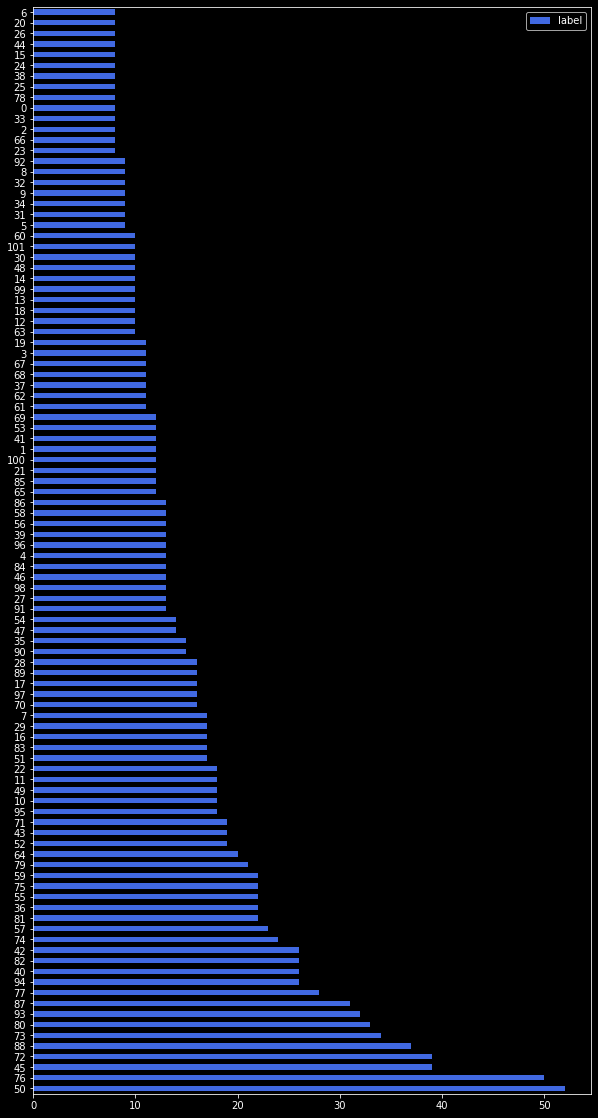

In [12]:
pd.DataFrame(validation['label'].value_counts(sort=True)).plot(kind='barh', figsize=(10, 20), color='royalblue')

<AxesSubplot:>

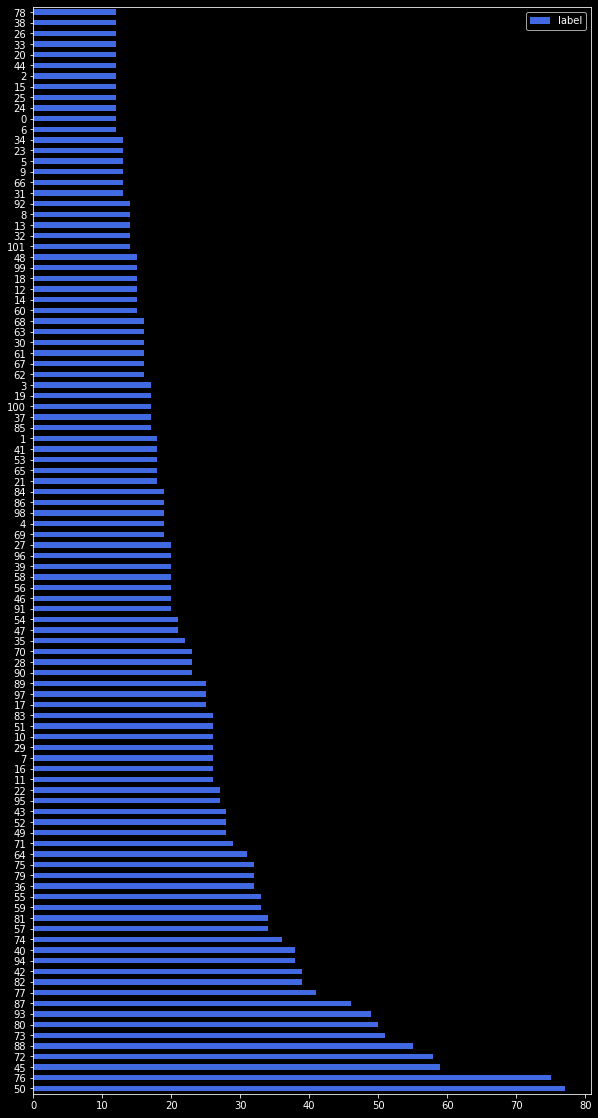

In [13]:
pd.DataFrame(test['label'].value_counts(sort=True)).plot(kind='barh', figsize=(10, 20), color='royalblue')

### Data augmentation

In [14]:
train_aug_datagen = ImageDataGenerator(
    rotation_range=45, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    brightness_range=[0.5, 1.5], 
    shear_range=0.15, 
    zoom_range=[0.75, 1.25], 
    fill_mode="nearest", 
    horizontal_flip=True, 
    rescale=1./255
)
train_aug = train_aug_datagen.flow_from_dataframe(
    dataframe=train, 
    directory=(DATA_PATH + 'images/'), 
    x_col='id', 
    y_col='label', 
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    shuffle=True, 
    seed=SEED
)

validation_aug_datagen = ImageDataGenerator(
    rescale=1./255
)
validation_aug = validation_aug_datagen.flow_from_dataframe(
    dataframe=validation, 
    directory=(DATA_PATH + 'images/'), 
    x_col='id', 
    y_col='label', 
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    shuffle=True, 
    seed=SEED
)

test_aug_datagen = ImageDataGenerator(
    rescale=1./255
)
test_aug = test_aug_datagen.flow_from_dataframe(
    dataframe=test, 
    directory=(DATA_PATH + 'images/'), 
    x_col='id', 
    y_col='label', 
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    shuffle=True, 
    seed=SEED
)

Found 4094 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.
Found 2457 validated image filenames belonging to 102 classes.


Esempio immagini "aumentate" del train set:


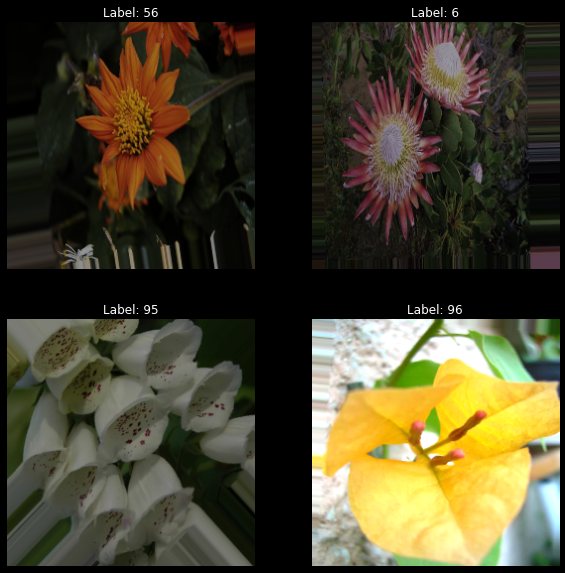

Esempio immagini "aumentate" del validation set:


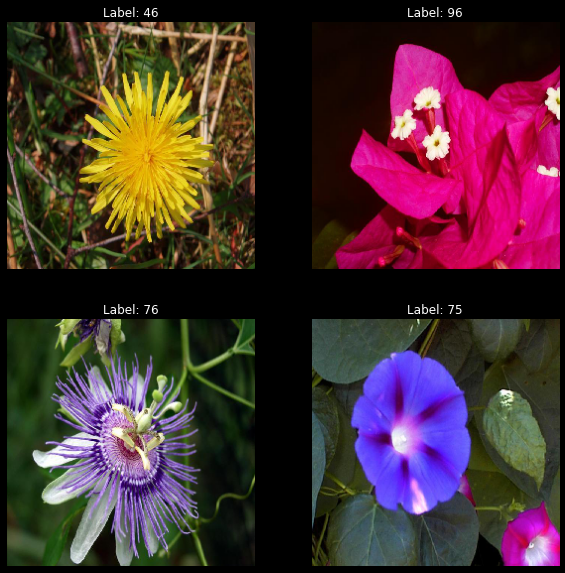

Esempio immagini "aumentate" del test set:


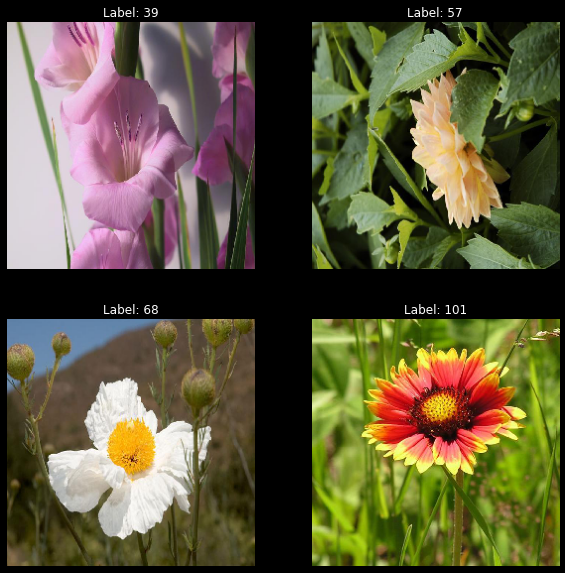

In [15]:
print('Esempio immagini "aumentate" del train set:')
show_random_images_aug(aug=train_aug)

print('Esempio immagini "aumentate" del validation set:')
show_random_images_aug(aug=validation_aug)

print('Esempio immagini "aumentate" del test set:')
show_random_images_aug(aug=test_aug)

## Model building

In [16]:
tensorflow.keras.backend.clear_session()

In [17]:
def create_model(BASE_MODEL, LR, DROPOUT_RATE, NUM_UNITS, ACTIVATION):
    model = Sequential()
    model.add(BASE_MODEL)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(NUM_UNITS, activation=ACTIVATION))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=Adam(lr=LR), 
        metrics=['accuracy']
    )
    
    return model

## Model training

In [ ]:
PARAMS = {
    'BASE_MODEL': [{'MODEL': model_resnet, 'NAME': 'RESNET50V2'}], # [{'MODEL': model_vgg, 'NAME': 'VGG16'}, {'MODEL':  model_xception, 'NAME': 'XCEPTION'}, {'MODEL': model_resnet, 'NAME': 'RESNET50V2'}],
    'LR': [1e-3], # [1e-3, 1e-4],
    'EPOCHS': [10], # 100
    'DROPOUT_RATE': [0.2], # 0.1, 0.3, 0.4, 0.5, 0.6
    'NUM_UNITS': [512], # [128, 256, 512],
    'ACTIVATION': ['elu'] # 'relu'
}

with open(DATA_PATH + 'results.csv', mode='w') as results:
    results_writer = csv.writer(results, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    results_writer.writerow(['EPOCHS', 'BATCH SIZE', 'BASE MODEL', 'DROPOUT RATE', 'LR', 'NUM UNITS', 'ACTIVATION', 'LOSS', 'ACCURACY', 'VALIDATION LOSS', 'VALIDATION ACCURACY'])

for EPOCHS in PARAMS['EPOCHS']:
    for BASE_MODEL in PARAMS['BASE_MODEL']:
        for DROPOUT_RATE in PARAMS['DROPOUT_RATE']:
            for LR in PARAMS['LR']:
                for NUM_UNITS in PARAMS['NUM_UNITS']:
                    for ACTIVATION in PARAMS['ACTIVATION']:
                        with open(DATA_PATH + 'results.csv', mode='a') as results:
                            results_writer = csv.writer(results, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

                            model = create_model(BASE_MODEL['MODEL'], LR, DROPOUT_RATE, NUM_UNITS, ACTIVATION)
                            model.summary()

                            history = model.fit(
                                train_aug,
                                validation_data=validation_aug,
                                epochs=EPOCHS,
                                callbacks=[CHECKPOINT, EARLYSTOP],
                                verbose=VERBOSE
                            )

                            print('[INFO] Model:\n\tBase model: ', BASE_MODEL['NAME'], '\n\tEpochs: ', EPOCHS, '\n\tLearning rate: ', LR, '\n\tBatch size: ', BATCH_SIZE, '\n\tNum units: ', NUM_UNITS, '\n\tActivation: ', ACTIVATION, '\n\tDropout rate: ', DROPOUT_RATE)
                            print('[TRAINING] Model:\n\tTrain loss: ', history.history['loss'][-1], '\n\tTrain accuracy: ', history.history['accuracy'][-1])
                            print('[VALIDATING] Model:\n\tValidation loss: ', history.history['val_loss'][-1], '\n\tValidation accuracy: ', history.history['val_accuracy'][-1])
                            plot_history(history)

                            results_writer.writerow([EPOCHS, BATCH_SIZE, BASE_MODEL['NAME'], DROPOUT_RATE, LR, NUM_UNITS, ACTIVATION, history.history['loss'][-1], history.history['accuracy'][-1], history.history['val_loss'][-1], history.history['val_accuracy'][-1]])
                            model.save(DATA_PATH + 'model_'+ str(EPOCHS) + '_' + str(BATCH_SIZE) + '_' + BASE_MODEL['NAME'] + '_' + str(DROPOUT_RATE) + '_' + str(LR) + '_' + str(NUM_UNITS) + '_' + ACTIVATION + '.hdf5')                        
                              
                            tensorflow.keras.backend.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 102)               52326     
Total params: 40,394,854
Trainable params: 16,830,054
Non-trainable params: 23,564,800
___________________________________

In [ ]:
FINAL_MODEL_NAME = 'XCEPTION'
FINAL_MODEL = model_xception
FINAL_LR = 1e-4
FINAL_DROPOUT_RATE = 0.2
FINAL_NUM_UNITS = 256
FINAL_ACTIVATION = 'elu'
FINAL_EPOCHS = 10

model = create_model(FINAL_MODEL, LR, DROPOUT_RATE, NUM_UNITS, ACTIVATION)
model.load_weights(model.save(DATA_PATH + 'model_'+ str(FINAL_EPOCHS) + '_' + str(BATCH_SIZE) + '_' + FINAL_MODEL_NAME + '_' + str(FINAL_DROPOUT_RATE) + '_' + str(FINAL_LR) + '_' + str(FINAL_NUM_UNITS) + '_' + FINAL_ACTIVATION + '.hdf5')

print('[WEIGHTS] Model:\n\tWeights: ', str(sum(abs(model.weights[6][0])).numpy()), '\n\tBiases: ', str(sum(abs(model.weights[6][0])).numpy()))
for layer in model.layers: print('Weights:\n\t', layer.get_weights())

## Model testing

In [ ]:
# change the path with the parameters of the best model to load the model

# kernel_regularizer
# test del modello migliore con un numero di epoche elevato!

score = model.evaluate(test_X_model_1_features_flatten, test_y, verbose=VERBOSE)
print('[TESTING] Model:\n\tTest loss: ', score[0], '\n\tTest accuracy: ', score[1])


from sklearn.metrics import accuracy_score

predictions = model.predict_generator(test_aug, verbose=VERBOSE) 
predictions = np.argmax(predictions, axis=-1)
label_map = (train_aug.class_indices)
label_map = dict((v, k) for k, v in label_map.items())
predictions = [label_map[k] for k in predictions]
submission = pd.DataFrame({'Predict': predictions}, columns=['Predict'], index=test_aug.filenames)
test_files.index = test_files['Id']
tmp_y = pd.concat([submission['Predict'], test_files['Category']], axis=1, sort=False)
tmp_y.head(5)
print('Accuracy: %.2f%%' % (accuracy_score(tmp_y['Category'], tmp_y['Predict'],)*100))